In [1]:
import sys
sys.path.insert(1, '/media/cinthia/Dados/Mestrado/mv-text-summarizer')

import glob, os
import pandas as pd
import json
import spacy
import nltk
import numpy as np
import json
#import seaborn as sns
import pickle


from bs4 import BeautifulSoup
from pysbd.utils import PySBDFactory
#from keras.callbacks import EarlyStopping
#from keras.models import model_from_json

#from keras.models import model_from_json
#from keras.callbacks import LearningRateScheduler
import math


#import keras
#from keras.optimizers import Adam
#from keras.layers import Dense, Flatten, Dropout, InputLayer
#from keras.models import Sequential
#from keras.wrappers.scikit_learn import KerasRegressor
#from sklearn.model_selection import train_test_split


%load_ext autoreload
%autoreload 2

from src import preprocess
from src import extract_features
from src import tokenizer
from src import create_features_df
from src import transform_data
from src import loader
from src import utils
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import random


rouge = RougeCalculator(stopwords=True, lang="en")


#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')
#nltk.download('punkt')

#!python -m spacy download en_core_web_sm
nlp_sm = spacy.load('en_core_web_sm')

#!python -m spacy download en_core_web_md
nlp_md = spacy.load('en_core_web_md')

import warnings
warnings.filterwarnings("ignore")

# Experimentos e Resultados

## Extração das Features

In [2]:
features_columns = ['sentences', 'text_rank', 'lex_rank', 'count_one_gram', 'count_two_gram',
       'count_three_gram', 'count_article_keywords', 'tf-isf',
       'position_score', 'paragraph_score', 'number_citations', 'length_score',
       'pos_score', 'ner_score', 'dist_centroid', 'articles']

In [3]:
scores_columns = ['rouge_1', 'rouge_2', 'rouge_l', 'label', 'articles']

In [4]:
embed_dim = 300
embeddings_columns = [i for i in range(embed_dim)]
embeddings_columns.append("article")

In [5]:
def array_to_df(array, columns_name):
    
    if (array.size != 0):
        return pd.DataFrame(array, columns=columns_name)

    return pd.DataFrame(columns=columns_name)

In [16]:
def extract_features_batches(batches, path_base, name_section, initial_batch=0,verbose=True):

    cont = initial_batch

    print("Name section: " + name_section)
    vfunc = np.vectorize(extract_features_file)
    
    print("Iniciando a extração de features...")
    
    for batch in batches:
        
        if verbose:
            print("Batch: {} \n".format(cont))
    
        #Load Files
        df = utils.load_batches(
            batch, path_base, name_section)
        
        if verbose:
            print("Total de arquivos: {} \n".format(df.shape))

        #Extract Features
        start = timer()
        features, scores, embeddings = vfunc(df['abstract'], df['texts'], df['keywords'], df['name_files'])
        print("Time:", timer()-start)
        
        # Convert numpy array to dataframe
        features = [array_to_df(features[i], features_columns) for i in range(len(features))]
        scores = [array_to_df(scores[i], scores_columns) for i in range(len(scores))]
        embeddings = [array_to_df(embeddings[i], embeddings_columns) for i in range(len(scores))]
                    
        print("Quantidade de arquivos processados: {}".format(len(features)))
        print("Saving Results")

        #Save Results
        utils.save_results(
        features, scores, embeddings,batch=cont, name_section=name_section, verbose=False)

        cont+=1
    

In [7]:
def extract_features_file(section, reference, keywords, number_text, verbose=False):
    
    xml = preprocess.format_xml(str(section))
    text = preprocess.format_text(str(section), post_processing=False)
    reference = preprocess.format_text(str(reference), post_processing=True)


    bibs = extract_features.get_citations(xml)
    text = preprocess.replace_bib(text, bibs)
    text = preprocess.format_text(text, post_processing=True)

    soup = BeautifulSoup(text)
    text = soup.get_text()

    sentences = tokenizer.split_sentences([text])
    sentences = list(map(str, sentences[0]))
    sentences = preprocess.format_sentences(sentences)

    try:

        features, embeddings = create_features_df.main(sentences, xml, keywords, nlp_sm, nlp_md)
        features_df = create_features_df.format_df (sentences, features)
        features_df['number_text'] = [number_text]*len(features_df)
        embeddings['numbert_tex'] = [number_text]*len(features_df)

        sentences_ref = tokenizer.split_sentences([reference])
        sentences_ref = list(map(str, sentences_ref[0]))

        scores_df, label = transform_data.main_create_label(sentences, sentences_ref, rouge)
        scores_df['label'] = label
        scores_df['number_text'] = [number_text]*len(scores_df)
        
    
        features = features_df.to_numpy(dtype=object)
        scores = scores_df.to_numpy(dtype=object)
        embeddings = embeddings.to_numpy(dtype=object)
        

        return features, scores, embeddings

    except IndexError as error:
        out = pd.DataFrame().to_numpy(dtype=object)
        return out, out, out
    except ValueError as error:
        out = pd.DataFrame().to_numpy(dtype=object)
        return out, out, out


In [8]:
def save_batches(batch_files):
    
    batches = {}
    for i in range(len(batch_files)):
        batches[i+1] =  list(batch_files[i])

    with open('batches_500.json', 'w') as f:
        json.dump(batches, f)

def create_batches(path_base, tam=45):

    files = os.listdir(path_base)
    batch_files = np.array_split(files,tam)

    return batch_files

In [9]:
path_base = "../../sumdata/dataset_articles"

if os.path.isfile('batches_500.json'):

    print("Load Batch Files")
    with open('batches_500.json') as f:
        batches = json.load(f)

    batch_files = [value for key, value in batches.items()]
else: 

    print("Creating Batch Files")
    batch_files = create_batches(path_base, tam=300)
    utils.save_batches(batch_files)

Load Batch Files


In [11]:
"""   
import shutil
import os

path='../result'
if os.path.exists(path):
    shutil.rmtree(path)           # Removes all the subdirectories!

os.makedirs(path)
os.makedirs(path + "/introduction")
os.makedirs(path + "/materials")
os.makedirs(path + "/conclusion") """   

In [10]:
from timeit import default_timer as timer  

In [ ]:
path_base = "../../sumdata/dataset_articles"
extract_features_batches(batch_files, path_base, name_section='materials', initial_batch=0, verbose=True)

Name section: materials
Iniciando a extração de features...
Batch: 0 

Total de arquivos: (159, 4) 

Time: 246.28550003400005
Quantidade de arquivos processados: 159
Saving Results
Batch: 1 

Total de arquivos: (159, 4) 

Time: 281.12031617899993
Quantidade de arquivos processados: 159
Saving Results
Batch: 2 

Total de arquivos: (159, 4) 

Time: 272.75243791599996
Quantidade de arquivos processados: 159
Saving Results
Batch: 3 

Total de arquivos: (159, 4) 

Time: 240.41097390899995
Quantidade de arquivos processados: 159
Saving Results
Batch: 4 

Total de arquivos: (159, 4) 

Time: 276.11602104600024
Quantidade de arquivos processados: 159
Saving Results
Batch: 5 

Total de arquivos: (159, 4) 

Time: 273.813332573
Quantidade de arquivos processados: 159
Saving Results
Batch: 6 

Total de arquivos: (159, 4) 



In [27]:
dataset='introduction'
features_df = loader.read_features(path="../result/{}/features_*.csv".format(dataset))

## Preparação dos dados 

Número de arquivos de treino e validação: 3848

Número de arquivos de teste: 384

In [10]:
def len_sentences_by_text(df):
    
    grouped = df.groupby(['number_text'])
    tam = []
    num = []

    for name, group in grouped:
        if len(group) >= 10 and len(group) <= 40:
            num.append(name)
            tam.append(len(group))

    return tam

In [28]:
def  load_preparation(X, y, dataset, train=False):

    columns_name = ['text_rank', 'lex_rank', 'count_one_gram', 'count_two_gram',
        'count_three_gram', 'count_article_keywords', 'tf-isf',
        'position_score', 'paragraph_score', 'number_citations', 'length_score',
        'pos_score', 'ner_score', 'dist_centroid']

    X = X[columns_name]
    y = y['rouge_1'] *100

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=47)

    print("\n{} - Tamanho da amostra de treino: {}".format(dataset, len(X_train)))
    print("{} - Tamanho da amostra de test: {}".format(dataset, len(X_test)))

    if train:
        scaler = StandardScaler()
        scaler.fit(X_train)
        pickle.dump(scaler, open('StandardScaler_{}'.format(dataset), 'wb'))
    else:
        infile = open('StandardScaler_{}'.format(dataset),'rb')
        scaler = pickle.load(infile)
        infile.close()

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X, y, X_train, X_test, y_train, y_test

In [24]:
def main(dataset, train=False): 

    features_df = loader.read_features(path="../result/{}/features_*.csv".format(dataset))
    scores_df = loader.read_features(path="../result/{}/scores_*.csv".format(dataset))

    print("Shape features para a {} - {}".format(dataset, features_df.shape))
    print("Shape features para a {} - {}".format(dataset, scores_df.shape))

    X, y, X_train, X_test, y_train, y_test = load_preparation(features_df, scores_df, dataset, train=train)

    result = pd.DataFrame({'gb':[], 'rf':[], 'mlp':[]})

    mse = 0
    mae = 0
    #mse, mae = pipeline_gb(dataset, X, y, X_train, y_train, X_test, y_test, train=train)
    result['gb'] = [mse, mae]
    #mse, mae = pipeline_rf(dataset, X, y, X_train, y_train, X_test, y_test, train=train)
    result['rf'] = [mse, mae]
    
    mse, mae = pipeline_neural_model(
        dataset,  X_train, y_train, X_test, y_test, validation_split=0.2, learning_rate=0.001,
        epochs=300, batch_size=64, verbose=0, train=train)
    result['mlp'] = [mse, mae]

    return features_df, scores_df, X_train, X_test, y_train, y_test, result

Epoch 1/300
2736/2736 [==============================] - 29s 10ms/step - loss: 10.0468 - mean_squared_error: 211.2190 - mean_absolute_error: 10.0468 - val_loss: 9.0254 - val_mean_squared_error: 173.2791 - val_mean_absolute_error: 9.0254
Epoch 2/300
2736/2736 [==============================] - 28s 10ms/step - loss: 9.2532 - mean_squared_error: 182.4400 - mean_absolute_error: 9.2532 - val_loss: 8.9818 - val_mean_squared_error: 171.4797 - val_mean_absolute_error: 8.9818
Epoch 3/300
2736/2736 [==============================] - 30s 11ms/step - loss: 9.1591 - mean_squared_error: 178.8032 - mean_absolute_error: 9.1591 - val_loss: 9.0275 - val_mean_squared_error: 180.2593 - val_mean_absolute_error: 9.0275
Epoch 4/300
2736/2736 [==============================] - 30s 11ms/step - loss: 9.1142 - mean_squared_error: 177.9492 - mean_absolute_error: 9.1142 - val_loss: 8.9456 - val_mean_squared_error: 170.5864 - val_mean_absolute_error: 8.9456
Epoch 5/300
2736/2736 [==============================] - 3

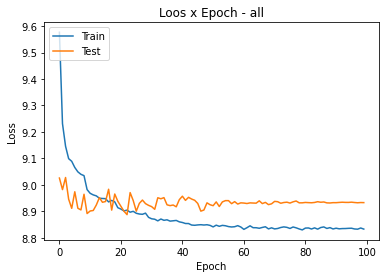

In [34]:
mse, mae = pipeline_neural_model(
    dataset,  X_train, y_train, X_test, y_test, validation_split=0.2, learning_rate=0.001,
    epochs=300, batch_size=128, verbose=1, train=True)


introduction - Tamanho da amostra de treino: 61550
introduction - Tamanho da amostra de test: 15388
Epoch 1/300
385/385 [==============================] - 13s 28ms/step - loss: 13.0748 - mean_squared_error: 361.2285 - mean_absolute_error: 13.0748 - val_loss: 10.2033 - val_mean_squared_error: 213.1908 - val_mean_absolute_error: 10.2033
Epoch 2/300
385/385 [==============================] - 10s 25ms/step - loss: 10.2287 - mean_squared_error: 200.2899 - mean_absolute_error: 10.2287 - val_loss: 9.5980 - val_mean_squared_error: 178.6870 - val_mean_absolute_error: 9.5980
Epoch 3/300
385/385 [==============================] - 10s 25ms/step - loss: 9.9981 - mean_squared_error: 193.9725 - mean_absolute_error: 9.9981 - val_loss: 9.5969 - val_mean_squared_error: 180.7103 - val_mean_absolute_error: 9.5969
Epoch 4/300
385/385 [==============================] - 10s 25ms/step - loss: 9.9123 - mean_squared_error: 192.6036 - mean_absolute_error: 9.9123 - val_loss: 9.5373 - val_mean_squared_error: 173.

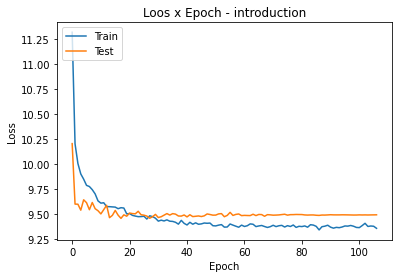

In [21]:

X, y, X_train, X_test, y_train, y_test = load_preparation(features_df, scores_df, dataset)

mse, mae = pipeline_neural_model(
    dataset,  X_train, y_train, X_test, y_test, validation_split=0.2, learning_rate=0.001,
    epochs=300, batch_size=128, verbose=1, train=True)

# Introdução

In [ ]:
path_base = "../../sumdata/dataset_articles"

Shape features para a introduction - (76938, 16)
Shape features para a introduction - (76938, 5)

introduction - Tamanho da amostra de treino: 61550
introduction - Tamanho da amostra de test: 15388

 Gradient Boost Hiperparâmetros
Num estimators: 200
Min samples leaf: 10
Min samples splot: 20
Max depth: 5
Best Score: 0.2552171838114866

 Random Forest Hiperparâmetros
Num estimators: 50
Min samples leaf: 20
Min samples splot: 40
Max depth: 7
Best Score: 0.024119128157676584


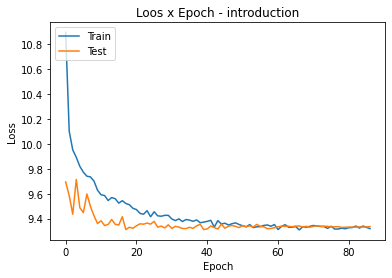

In [ ]:
dataset='introduction'
features_intro, scores_intro, X_train, X_test, y_train, y_test, result_intro = main(dataset, train=False)

## Materials and Methods

Shape features para a materials - (172234, 16)
Shape features para a materials - (172234, 5)

materials - Tamanho da amostra de treino: 137787
materials - Tamanho da amostra de test: 34447

 Gradient Boost Hiperparâmetros
Num estimators: 50
Min samples leaf: 10
Min samples splot: 20
Max depth: 5
Best Score: 0.009325638415237725

 Random Forest Hiperparâmetros
Num estimators: 100
Min samples leaf: 20
Min samples splot: 40
Max depth: 7
Best Score: 0.008664772857182302


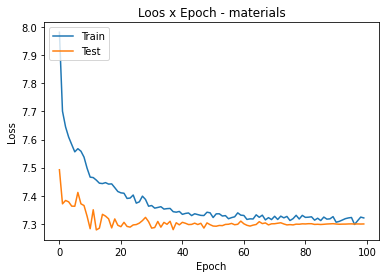

In [38]:
dataset='materials'
features_mat, scores_mat, X_train, X_test, y_train, y_test, result_mat = main(dataset, train=False)

## Conclusion

Shape features para a conclusion - (297889, 16)
Shape features para a conclusion - (297889, 5)

conclusion - Tamanho da amostra de treino: 238311
conclusion - Tamanho da amostra de test: 59578

 Gradient Boost Hiperparâmetros
Num estimators: 200
Min samples leaf: 10
Min samples splot: 20
Max depth: 5
Best Score: 0.2552171838114866

 Random Forest Hiperparâmetros
Num estimators: 200
Min samples leaf: 20
Min samples splot: 40
Max depth: 7
Best Score: 0.2191141161210636


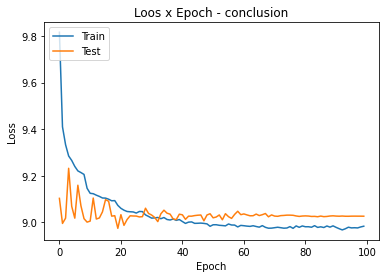

In [39]:
dataset='conclusion'
features_conc, scores_conc, X_train, X_test, y_train, y_test, result_conc = main(dataset, train=False)

## Resultados da Avaliação dos modelos na base de teste

Cada algoritmo é treinado com o conjunto de hiperparâmetros obtidos anteriormente na base de treino e os resultados na base de teste são apresentados nas tabelas abaixo.

É possível ver que a rede MLP e o GB apresentam resultados superiores aos do RF e similares entre si. Esse comportamente se mantém nos testes de sumarização que são apresentados na próxima seção.

Linha 0 - MAE

Linha 1 - MSE

In [40]:
result_intro

,gb,rf,mlp
0,163.947292,173.243343,167.101167
1,9.447179,9.781518,9.250687


In [41]:
result_mat

,gb,rf,mlp
0,118.328920,121.440611,129.537783
1,7.554799,7.652398,7.323716


In [42]:
result_conc

,gb,rf,mlp
0,163.125807,171.181866,172.586313
1,9.081223,9.327374,9.056795


## Avaliação da Tarefa de Sumarização

Os dados aqui apresentados são relativos a tarefa de sumarização, os testes foram feitos em 71 arquivos selecionados aleatoriamente e esses arquivos não fazem parte da base de treino e teste. Todos or arquivos estão completos e a sumarização é realizada para cada um, separadamente.  

Para avaliar os modelos são utilizadas as métricas ROUGE-1, ROUGE-2 e ROUGE-L. 

### Suppress code

### Resultados

In [50]:
mlp_model_intro, scaler_intro = load_summarize_models(model='mlp', dataset='introduction')
mlp_model_mat, scaler_mat = load_summarize_models(model='mlp', dataset='materials')
mlp_model_conc, scaler_conc = load_summarize_models(model='mlp', dataset='conclusion')

path = "../sumdata/introduction/features_*"
summaries_mlp = summarizer_all_texts(mlp_model_intro, scaler_intro, mlp_model_mat, scaler_mat, mlp_model_conc, scaler_conc, path)
summaries_mlp.to_csv("summaries_mlp.csv", index = False)
scores_mlp = evaluation_all_summaries(summaries_mlp)

In [51]:
gb_model_intro, _ = load_summarize_models(model='gb', dataset='introduction')
gb_model_mat, _ = load_summarize_models(model='gb', dataset='materials')
gb_model_conc, _ = load_summarize_models(model='gb', dataset='conclusion')

path = "../sumdata/introduction/features_*"
summaries_gb = summarizer_all_texts(gb_model_intro, scaler_intro, gb_model_mat, scaler_mat, gb_model_conc, scaler_conc, path)
summaries_gb.to_csv("summaries_gb.csv", index = False)
scores_gb = evaluation_all_summaries(summaries_gb)

In [52]:
rf_model_intro, _ = load_summarize_models(model='rf', dataset='introduction')
rf_model_mat, _ = load_summarize_models(model='rf', dataset='materials')
rf_model_conc, _ = load_summarize_models(model='rf', dataset='conclusion')

path = "../sumdata/introduction/features_*"
summaries_rf = summarizer_all_texts(rf_model_intro, scaler_intro, rf_model_mat, scaler_mat, rf_model_conc, scaler_conc, path)
summaries_rf.to_csv("summaries_rf.csv", index = False)
scores_rf = evaluation_all_summaries(summaries_rf)

In [53]:
scores_mlp.describe().T

,count,mean,std,min,25%,50%,75%,max
intro_r1,71.0,0.284745,0.092789,0.083770,0.216374,0.294118,0.357375,0.500000
intro_r2,71.0,0.108754,0.079902,0.000000,0.054670,0.091324,0.144107,0.430769
intro_r3,71.0,0.183563,0.072115,0.041885,0.133894,0.173469,0.218081,0.469697
mat_r1,71.0,0.141949,0.078060,0.000000,0.086800,0.120482,0.184820,0.364372
mat_r2,71.0,0.041478,0.050602,0.000000,0.010211,0.024691,0.055972,0.233333
mat_rl,71.0,0.097280,0.056947,0.000000,0.058968,0.090000,0.129454,0.299595
conc_r1,71.0,0.257959,0.070991,0.071006,0.216448,0.255319,0.314650,0.406504
conc_r2,71.0,0.089224,0.051907,0.000000,0.046465,0.083721,0.131373,0.185792
conc_rl,71.0,0.167098,0.047582,0.047337,0.136054,0.163743,0.205670,0.278607
merged_r1,71.0,0.367071,0.076714,0.226721,0.312228,0.367647,0.423158,0.544850


In [54]:
scores_gb.describe().T

,count,mean,std,min,25%,50%,75%,max
intro_r1,71.0,0.288521,0.089273,0.115942,0.222813,0.287234,0.354921,0.528571
intro_r2,71.0,0.110267,0.075131,0.000000,0.050651,0.101266,0.147990,0.420290
intro_r3,71.0,0.187197,0.074604,0.072464,0.131602,0.186667,0.219219,0.514286
mat_r1,71.0,0.139153,0.071048,0.000000,0.093455,0.125786,0.167015,0.364372
mat_r2,71.0,0.040277,0.049092,0.000000,0.010211,0.024845,0.052185,0.242424
mat_rl,71.0,0.095860,0.056819,0.000000,0.061576,0.082474,0.113402,0.300429
conc_r1,71.0,0.258114,0.070387,0.083333,0.208825,0.259414,0.306164,0.435644
conc_r2,71.0,0.087115,0.050833,0.000000,0.044806,0.083721,0.124578,0.241206
conc_rl,71.0,0.171213,0.051194,0.070175,0.134961,0.167401,0.206897,0.308458
merged_r1,71.0,0.367378,0.084124,0.193548,0.305329,0.379447,0.427123,0.555556


In [55]:
scores_rf.describe().T

,count,mean,std,min,25%,50%,75%,max
intro_r1,71.0,0.283802,0.084546,0.115942,0.222222,0.275000,0.346786,0.528571
intro_r2,71.0,0.110161,0.072852,0.000000,0.064161,0.100000,0.137533,0.420290
intro_r3,71.0,0.187552,0.070517,0.072464,0.137934,0.181034,0.219092,0.514286
mat_r1,71.0,0.134302,0.070506,0.000000,0.088254,0.133333,0.168182,0.321951
mat_r2,71.0,0.037262,0.044938,0.000000,0.007766,0.025641,0.048812,0.232759
mat_rl,71.0,0.092474,0.051349,0.000000,0.054487,0.086957,0.113402,0.271186
conc_r1,71.0,0.251143,0.075040,0.094737,0.200000,0.247934,0.306592,0.477064
conc_r2,71.0,0.087336,0.055779,0.000000,0.047603,0.084848,0.116212,0.251429
conc_rl,71.0,0.163517,0.057974,0.063158,0.120798,0.155689,0.195033,0.305085
merged_r1,71.0,0.354518,0.084451,0.151351,0.290412,0.359551,0.424450,0.541254


# Exemplos de resumos gerados

In [ ]:
summaries_mlp =pd.read_csv("summaries_mlp.csv")

In [63]:
n = 30

In [64]:
#Ground Truth
summaries_mlp['reference'][n]

'The present research examined developmental and gender differences in the relative accessibility of different gender stereotype domains. A Northeastern US sample of children ages to years old provided open ended descriptions of girls and boys. Responses were coded by domain to examine differences by grade, gender of participant, and gender of target. Analyses revealed that girls and older children provided a higher proportion of stereotypes, and that appearance stereotypes were particularly prevalent in descriptions of girls and activity/trait stereotypes were more prevalent in descriptions of boys. Results are discussed in terms of implications for research on the stereotype knowledgebehavior link and the need for more attention to the role of appearance stereotypes in the gender stereotype literature.'

In [65]:
summaries_mlp['intro'][n]

'To the best of our knowledge, no study to date has examined accessibility differences of gender stereotype domains in young children. Children’s gender concepts may be similarly differentiated in structure, which could have important implications for how we understand gender stereotype development in children . Therefore, boys may endorse stronger gender stereotypical preferences than girls, but only in the domain of activities and toys.'

In [66]:
summaries_mlp['mat'][n]

'Prior research on gender stereotype domains guided the development of the coding scheme that was used to categorize children’s responses. For the present study, children’s responses were coded into general categories based on their stereotyped nature and into sub categories based on their domains. These domain specific proportions were calculated by dividing the number of stereotyped responses for a given domain divided by the total number of statements .'

In [62]:
summaries_mlp['conc'][0]

'We conclude that the specific movement of grk RNA particles in the nurse cells along straight paths to the ring canals is MT dependent . We conclude that the transport of grk RNA within the nurse cells towards ring canals and from the nurse cell to the oocyte is Dynein dependent . Within nurse cells, we have identified a new path of Dynein dependent transport to the ring canals that link the nurse cells to the oocyte.'